In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.mixture import GaussianMixture
import numpy as np

In [46]:
data_cleaned = pd.read_csv('/content/sample_data/data_cleaned.csv')

In [47]:
data_cleaned['Income_Per_Age'] = data_cleaned['Annual Income (k$)'] / (data_cleaned['Age'] + 1)  # Avoid division by zero
data_cleaned['Spending_Income_Ratio'] = data_cleaned['Spending Score (1-100)'] / data_cleaned['Annual Income (k$)']
features = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_Per_Age', 'Spending_Income_Ratio']


In [48]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned[features])

# Outlier Removal using Z-Score method
z_scores = np.abs(stats.zscore(data_scaled))
data_cleaned_no_outliers = data_cleaned[(z_scores < 3).all(axis=1)]
data_scaled_no_outliers = scaler.fit_transform(data_cleaned_no_outliers[features])

In [49]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled_no_outliers)

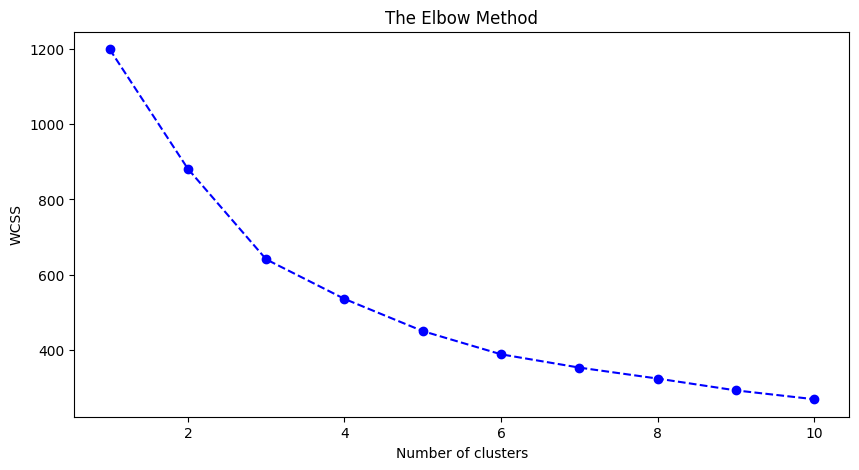

In [50]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [51]:
#Strategy 1: Gaussian Mixture Model (GMM) for clustering
gmm = GaussianMixture(n_components=4, random_state=42)
data_cleaned_no_outliers.loc[:, 'GMM_Cluster'] = gmm.fit_predict(data_pca)
gmm_silhouette_avg = silhouette_score(data_pca, data_cleaned_no_outliers['GMM_Cluster'])
print(f'Silhouette Score for GMM with 4 clusters: {gmm_silhouette_avg}')


Silhouette Score for GMM with 4 clusters: 0.512168783582509


<ipython-input-51-63e0156ca287>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_no_outliers.loc[:, 'GMM_Cluster'] = gmm.fit_predict(data_pca)


In [52]:
# Strategy 2: Try K-Means with hyperparameter tuning
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=50, max_iter=500, random_state=42)
data_cleaned_no_outliers.loc[:, 'KMeans_Cluster'] = kmeans.fit_predict(data_pca)
kmeans_silhouette_avg = silhouette_score(data_pca, data_cleaned_no_outliers['KMeans_Cluster'])
print(f'Silhouette Score for K-Means with 4 clusters: {kmeans_silhouette_avg}')

Silhouette Score for K-Means with 4 clusters: 0.515485823032567


<ipython-input-52-bca4f2ff3b6a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_no_outliers.loc[:, 'KMeans_Cluster'] = kmeans.fit_predict(data_pca)


In [53]:
#Strategy 3: DBSCAN Clustering for density-based clusters
dbscan = DBSCAN(eps=0.3, min_samples=5)
data_cleaned_no_outliers.loc[:, 'DBSCAN_Cluster'] = dbscan.fit_predict(data_pca)

# Filter out noise points (-1) for silhouette calculation
mask = data_cleaned_no_outliers['DBSCAN_Cluster'] != -1
labels_dbscan = data_cleaned_no_outliers.loc[mask, 'DBSCAN_Cluster']
data_pca_filtered = data_pca[mask]

if len(np.unique(labels_dbscan)) > 1:  # Check if there are at least 2 clusters
    dbscan_silhouette_avg = silhouette_score(data_pca_filtered, labels_dbscan)
    print(f'Silhouette Score for DBSCAN: {dbscan_silhouette_avg}')
else:
    print("DBSCAN could not form clusters, too many noise points.")


Silhouette Score for DBSCAN: 0.6265212906437424


<ipython-input-53-590856bc82f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_no_outliers.loc[:, 'DBSCAN_Cluster'] = dbscan.fit_predict(data_pca)


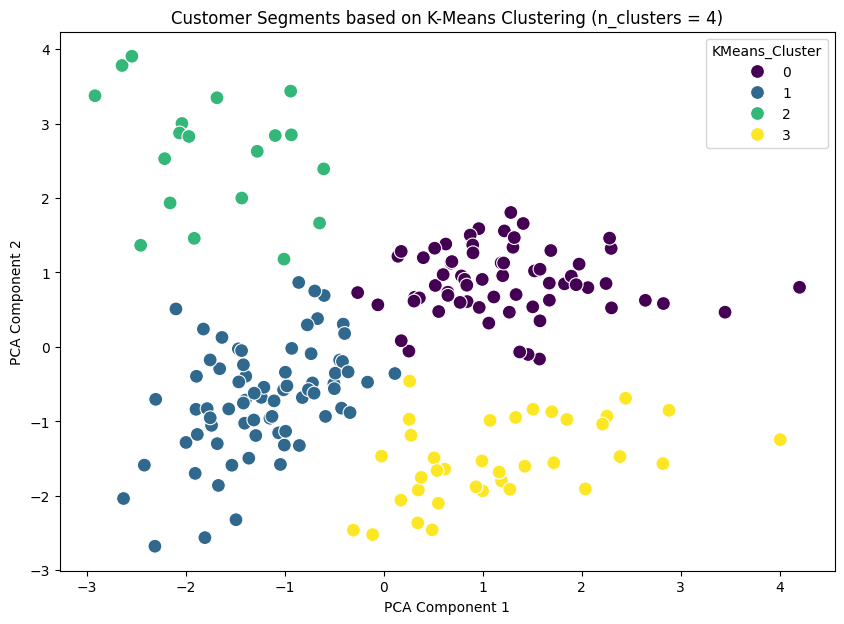

In [54]:
# Visualization for K-Means (best so far)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=data_pca[:, 0],
    y=data_pca[:, 1],
    hue=data_cleaned_no_outliers['KMeans_Cluster'],
    palette='viridis',
    s=100
)
plt.title('Customer Segments based on K-Means Clustering (n_clusters = 4)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

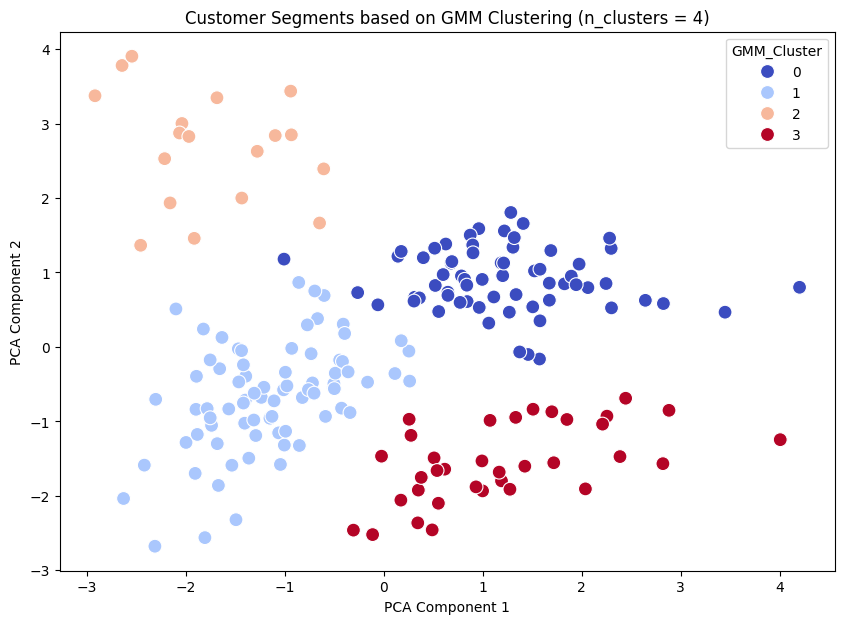

In [55]:
# Visualization for GMM
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=data_pca[:, 0],
    y=data_pca[:, 1],
    hue=data_cleaned_no_outliers['GMM_Cluster'],
    palette='coolwarm',
    s=100
)
plt.title('Customer Segments based on GMM Clustering (n_clusters = 4)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()